# Metodologia de Classificação Climática de Cidades  
**Autor:** John Costa

**Fontes dos Dados:**  
- [Instituto Português do Mar e da Atmosfera (IPMA)](https://www.ipma.pt/)
- [World Weather Online](https://www.worldweatheronline.com/)
- [Open-Meteo](https://open-meteo.com/)
- [Shape Portugal - Natural Earth](https://www.naturalearthdata.com/)

---

## Objetivo

Este documento explica de forma simples e transparente como é realizada a classificação do clima das cidades de Portugal (e exemplos do Brasil), detalhando a lógica do cálculo do score climático, os critérios para eventos extremos, a metodologia dos índices e as influências dos fatores naturais e humanos no clima. Exemplos reais ilustram cada etapa.

---

## 1. **Elementos e Fatores Climáticos**

### **Elementos do Clima**  
Características do ambiente que sentimos ou medimos no dia a dia:

- **Temperatura:** grau de calor do ar.
- **Umidade:** quantidade de vapor d’água presente no ar.
- **Pressão atmosférica:** força do ar sobre a superfície.
- **Precipitação:** chuva, neve ou granizo.
- **Ventos:** movimentação do ar.
- **Radiação solar:** energia recebida do Sol.

### **Fatores Climáticos**  
Aspectos que modificam ou influenciam os elementos:

| Fator                | Como influencia a temperatura e outros elementos                       | Exemplo prático                         |
|----------------------|-----------------------------------------------------------------------|-----------------------------------------|
| **Latitude**         | Próximo ao Equador = mais quente; longe = mais frio                   | Algarve mais quente que Porto           |
| **Altitude/Relevo**  | Locais altos = mais frio                                              | Serra da Estrela com neve               |
| **Maritimidade**     | Próximo ao mar = menos variação térmica                               | Lisboa com invernos mais amenos         |
| **Continentalidade** | Interior = maior variação entre verão e inverno                       | Interior do Alentejo mais extremo       |
| **Correntes Marítimas** | Correntes frias/quentes afetam temperatura do litoral               | Corrente do Golfo suaviza litoral oeste |
| **Uso/Ocupação do Solo** | Cidades são mais quentes (ilhas de calor), menos vegetação         | Centro de Lisboa mais quente            |

---

## 2. **Aparelhos de Medição Climática**

- **Termômetro:** mede temperatura do ar.
- **Pluviómetro:** mede a quantidade de chuva (mm).
- **Higrômetro:** mede a umidade relativa do ar.
- **Barômetro:** mede a pressão atmosférica.
- **Anemômetro:** mede a velocidade dos ventos.
- **Heliógrafo:** mede horas de sol.
- **Biruta:** indica a direção do vento.

As medições são realizadas em estações meteorológicas espalhadas nas cidades.

---

## 3. **Metodologia de Classificação**

### **a) Identificação de Eventos Extremos**

Um dia é considerado extremo se atender ao menos um dos critérios abaixo:
- **Calor extremo:** máxima > 35°C ou Heat Index > 40°C
- **Frio extremo:** mínima < 1°C ou Wind Chill < -5°C
- **Chuva extrema:** precipitação diária acima de 35 mm
- **Neve:** qualquer valor positivo em Portugal continental
- **UV extremo:** índice ≥ 8

### **b) Cálculo do "Clima Típico" e do Score Diário**

- Os scores e classificações são **calculados diariamente** para cada cidade, já considerando as penalizações por eventos extremos do próprio dia.
- Posteriormente, são feitos resumos mensais e anuais, utilizando a média dos scores diários e o registro da frequência de eventos extremos.

### **c) Score de Conforto Climático**

O score diário parte de 100 pontos e utiliza os seguintes pesos para as variáveis, sempre priorizando conforto humano:

- **Temperatura máxima ideal (20 a 28°C):** 60%
- **Temperatura mínima ideal (16 a 20°C):** 12%
- **Umidade relativa (30-80%):** 10%
- **Sol (≥ 5h/dia):** 9%
- **Precipitação (≤ 20mm/dia):** 9%

O score pode ser penalizado no próprio dia em caso de extremos:

- **Calor extremo:** penaliza 0,3 no cálculo (equivale a até -6 pontos por dia)
- **Frio extremo:** penaliza 0,4 (até -8 pontos por dia)
- **Chuva extrema:** penaliza 0,2 (até -4 pontos por dia)

*A penalização máxima diária é limitada a -20 pontos.*

### **d) Classificação Final**

| Score         | Classificação |
|---------------|--------------|
| ≥ 80          | Excelente    |
| 70 a 79,99    | Muito Bom    |
| 60 a 69,99    | Bom          |
| 50 a 59,99    | Aceitável    |
| < 50          | Marginal     |

---

## 4. **Exemplo de Aplicação**

*Valores ilustrativos para facilitar o entendimento:*

### **Lisboa**
- Máxima média: 25,6°C
- Mínima média: 15,8°C
- Umidade: 69%
- Chuva: 1,9 mm/dia
- Dias extremos: 2 de calor, 0 de frio, 2 de chuva
- **Score:** 88,4 → **Classificação: Excelente**

### **Porto**
- Máxima média: 22,8°C
- Mínima média: 12,5°C
- Umidade: 74%
- Chuva: 2,8 mm/dia
- Dias extremos: 0 de calor, 0 de frio, 3 de chuva
- **Score:** 81,2 → **Classificação: Excelente**

### **São Paulo (Brasil)**
- Máxima média: 28,3°C
- Mínima média: 16,9°C
- Umidade: 64%
- Chuva: 2,0 mm/dia
- Dias extremos: 9 de calor, 0 de frio, 23 de chuva
- **Score:** 62,1 → **Classificação: Bom**

---

## 5. **Visualização no Mapa**

Cada cidade foi plotada em um mapa de Portugal, colorida conforme a classificação:
- **Azul:** Excelente / Muito Bom
- **Verde:** Bom
- **Amarelo:** Aceitável
- **Vermelho:** Marginal

*<sub>Sugestão: Utilize bibliotecas como `geopandas` e `matplotlib` para criar o mapa. Exemplo disponível na documentação técnica.</sub>*

---

## 6. **Considerações**

- Os dados usados são médias diárias; podem ocorrer limitações para eventos de chuva intensa em curto período.
- Os extremos são baseados em referências de saúde pública e médias portuguesas.
- A metodologia busca um equilíbrio entre conforto humano e variabilidade natural do clima, facilitando comparação entre cidades.
- O método é inspirado no Tourism Climate Index (TCI) e adaptado para avaliação do conforto urbano.

---

## 7. **Referências**

- IPMA - Instituto Português do Mar e da Atmosfera ([site](https://www.ipma.pt/))
- World Weather Online ([site](https://www.worldweatheronline.com/))
- Mieczkowski, Z. (1985). The Tourism Climate Index: A Method of Evaluating World Climates for Tourism.
- Artigos de Meteorologia, sites oficiais de institutos e literatura de conforto climático.


In [145]:
#!pip install geopandas
#!pip install plotly

In [176]:
import pandas as pd
import numpy as np
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.express as px
import pandas as pd

# === FUNÇÕES DE DETECÇÃO DE EVENTOS EXTREMOS ===
def is_hot_extreme(row):
    """Evento de calor extremo: Temperatura máxima > 35°C OU Heat Index > 40°C."""
    return row['maxtempC'] > 35 or row['HeatIndexC'] > 40

def is_cold_extreme(row):
    """Evento de frio extremo: Temperatura mínima < 1°C OU Wind Chill < -5°C."""
    return row['mintempC'] < 1 or row['WindChillC'] < -5

def is_rain_extreme(row):
    """Evento de chuva extrema: Precipitação diária > 35 mm."""
    return row['precipMM'] > 35

def is_snow_extreme(row):
    """Evento de neve: Qualquer valor positivo já é extremo em Portugal continental."""
    return row['totalSnow_cm'] > 0

def is_uv_extreme(row):
    """Radiação UV extrema: Índice UV >= 8 (OMS: muito alto)."""
    return row['uvIndex'] >= 8

# === FUNÇÕES AUXILIARES ===
def assign_season(month):
    if month in [12, 1, 2]:
        return 'Inverno'
    elif month in [3, 4, 5]:
        return 'Primavera'
    elif month in [6, 7, 8]:
        return 'Verão'
    else:
        return 'Outono'

def classify_city_index(score):
    if score >= 80:
        return 'Excelente'
    elif score >= 70:
        return 'Muito Bom'
    elif score >= 60:
        return 'Bom'
    elif score >= 50:
        return 'Aceitável'
    else:
        return 'Marginal'

# === CÁLCULO DO TCI - Tourism Climate Index (continua mensal!) ===
def compute_tci_monthly(df):
    df = df.copy()
    df['month'] = df['date_time'].dt.month
    tci_list = []
    for (year, month), dfg in df.groupby([df['date_time'].dt.year, 'month']):
        # ---- CID: conforto diário (temp média)
        tmean = dfg['tempC'].mean()
        rhmean = dfg['humidity'].mean()
        if 20 <= tmean <= 27:
            cid = 10
        elif 16 <= tmean < 20 or 27 < tmean <= 30:
            cid = 7
        elif 13 <= tmean < 16 or 30 < tmean <= 33:
            cid = 5
        elif 10 <= tmean < 13 or 33 < tmean <= 36:
            cid = 3
        else:
            cid = 0
        if rhmean > 90 or rhmean < 30:
            cid -= 1

        # ---- CIA: conforto amplitude diária (temp máxima)
        tmax = dfg['maxtempC'].mean()
        rhmax = dfg['humidity'].mean()
        if 20 <= tmax <= 27:
            cia = 10
        elif 16 <= tmax < 20 or 27 < tmax <= 30:
            cia = 7
        elif 13 <= tmax < 16 or 30 < tmax <= 33:
            cia = 5
        elif 10 <= tmax < 13 or 33 < tmax <= 36:
            cia = 3
        else:
            cia = 0
        if rhmax > 90 or rhmax < 30:
            cia -= 1

        # ---- P: índice de precipitação do mês
        p = dfg['precipMM'].sum()
        if p <= 30:
            pi = 10
        elif p <= 60:
            pi = 7
        elif p <= 90:
            pi = 5
        elif p <= 120:
            pi = 3
        else:
            pi = 0

        # ---- S: insolação média diária
        s = dfg['sunHour'].mean()
        if s >= 9:
            si = 10
        elif s >= 7:
            si = 7
        elif s >= 5:
            si = 5
        elif s >= 3:
            si = 3
        else:
            si = 0

        # ---- W: vento médio no mês
        w = dfg['windspeedKmph'].mean()
        if w < 15:
            wi = 10
        elif w < 25:
            wi = 7
        elif w < 35:
            wi = 5
        elif w < 45:
            wi = 3
        else:
            wi = 0

        tci = 2*cid + 2*cia + 0.5*pi + 0.5*si + wi
        tci = max(0, min(100, tci))
        tci_list.append({'ano': year, 'mes': month, 'tci': tci})

    tci_df = pd.DataFrame(tci_list)
    tci_annual = tci_df['tci'].mean() if not tci_df.empty else np.nan
    return tci_annual, tci_df

# === NOVO: SCORE DIÁRIO E MARCAÇÃO DE EXTREMOS ===
def marcar_extremo(row):
    """Retorna True se houver qualquer evento extremo (calor, frio, chuva, neve)"""
    return (
        is_hot_extreme(row) or
        is_cold_extreme(row) or
        is_rain_extreme(row) or
        is_snow_extreme(row)
    )

def score_dia(row):
    maxtemp = row['maxtempC']
    mintemp = row['mintempC']
    humidity = row['humidity']
    sun = row['sunHour']
    precip = row['precipMM']

    # Conforto máxima
    ideal_temp = 1 if (20 <= maxtemp <= 28) else 0
    moderate_temp = 1 if (18 < maxtemp < 32) else 0
    comfort_temp = 0.7 * ideal_temp + 0.3 * moderate_temp

    # Conforto mínima (peso de 15%)
    if 16 <= mintemp <= 20:
        comfort_mintemp = 1
    elif 13 <= mintemp < 16 or 20 < mintemp <= 22:
        comfort_mintemp = 0.7
    elif 10 <= mintemp < 13 or 22 < mintemp <= 24:
        comfort_mintemp = 0.4
    else:
        comfort_mintemp = 0

    comfort_hum = 1 if (30 <= humidity <= 80) else 0
    comfort_sun = 1 if sun >= 5 else 0
    comfort_precip = 1 if precip <= 20 else 0

    penalizacao = 0
    if is_hot_extreme(row): penalizacao += 0.3
    if is_cold_extreme(row): penalizacao += 0.4
    if is_rain_extreme(row): penalizacao += 0.2

    penalizacao = min(penalizacao, 1)

    # Score ponderado (máxima 50%, mínima 15%, umidade 10%, sol 10%, chuva 10%)
    score = 100 * (
        0.6 * comfort_temp +
        0.12 * comfort_mintemp +
        0.10 * comfort_hum +
        0.09 * comfort_sun +
        0.09 * comfort_precip
    )
    score -= penalizacao * 20
    return max(score, 0)


# Função para classificar score diário
def classifica_score(score):
    if score >= 80:
        return 'Excelente'
    elif score >= 70:
        return 'Muito Bom'
    elif score >= 60:
        return 'Bom'
    elif score >= 50:
        return 'Aceitável'
    else:
        return 'Marginal'

# === LEITURA DE MÚLTIPLOS CSVs DE UMA PASTA (mantida) ===
def load_weather_data(folder_path, min_days=365):
    
    # Lista dos nomes das colunas (caso leia de um CSV sem cabeçalho)
    colunas = [
        'date_time','maxtempC','mintempC','totalSnow_cm','sunHour','uvIndex','moon_illumination',
        'moonrise','moonset','sunrise','sunset','DewPointC','FeelsLikeC','HeatIndexC','WindChillC',
        'WindGustKmph','cloudcover','humidity','precipMM','pressure','tempC','visibility',
        'winddirDegree','windspeedKmph','location'
    ]

    # Dicionário de tipos para cada coluna
    tipos = {
        'date_time': 'datetime64[ns]',
        'maxtempC': 'Int64',
        'mintempC': 'Int64',
        'totalSnow_cm': 'float',
        'sunHour': 'float',
        'uvIndex': 'Int64',
        'moon_illumination': 'Int64',
        'moonrise': 'string',
        'moonset': 'string',
        'sunrise': 'string',
        'sunset': 'string',
        'DewPointC': 'Int64',
        'FeelsLikeC': 'Int64',
        'HeatIndexC': 'Int64',
        'WindChillC': 'Int64',
        'WindGustKmph': 'Int64',
        'cloudcover': 'Int64',
        'humidity': 'Int64',
        'precipMM': 'float',
        'pressure': 'Int64',
        'tempC': 'Int64',
        'visibility': 'Int64',
        'winddirDegree': 'Int64',
        'windspeedKmph': 'Int64',
        'location': 'string'
    }

    dfs = []
    arquivos_descartados = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path, parse_dates=['date_time'])
            city_name = filename.split(',')[0].replace("+", " ")
            df['municipio'] = city_name

            num_dias = df['date_time'].nunique()
            periodo = df['date_time'].max() - df['date_time'].min()

            if num_dias >= min_days:
                dfs.append(df)
            else:
                arquivos_descartados.append((filename, num_dias, periodo.days))

    print("\nArquivos descartados (menos de", min_days, "dias de histórico):")
    for nome, dias, periodo in arquivos_descartados:
        print(f"{nome}: {dias} dias distintos, período coberto: {periodo} dias")

    if not dfs:
        print("Nenhum arquivo com histórico suficiente.")
        return pd.DataFrame()

    combined_df = pd.concat(dfs, ignore_index=True)

    # Converte as colunas de acordo com o dicionário de tipos
    for col, tipo in tipos.items():
        if tipo == 'datetime64[ns]':
            combined_df[col] = pd.to_datetime(combined_df[col])
        else:
            combined_df[col] = combined_df[col].astype(tipo)

    return combined_df

def formatar_numericos(df):
    df = df.copy()  # Cria uma cópia, o original não será alterado!
    for col in df.select_dtypes(include='number').columns:
        df[col] = df[col].apply(lambda x: '{:,.2f}'.format(x).replace(',', 'X').replace('.', ',').replace('X', '.'))
    return df

def resumo_mensal(df):
    resumo_mensal = df.groupby(['Regiao','municipio', 'ano_mes','estacao']).agg(
        dias_no_mes = ('classificacao_dia', 'count'),
        dias_bons = ('classificacao_dia', lambda x: (x.isin(['Excelente','Muito Bom','Bom'])).sum()),
        dias_aceitaveis = ('classificacao_dia', lambda x: (x == 'Aceitável').sum()),
        dias_marginais = ('classificacao_dia', lambda x: (x == 'Marginal').sum()),
        extremos = ('evento_extremo', 'sum'),
        percentual_extremos = ('evento_extremo', lambda x: 100*x.sum()/len(x)),
        media_score = ('score_dia', 'mean'),
        score_max = ('score_dia', 'max'),
        score_min = ('score_dia', 'min'),
        score_std = ('score_dia', 'std'),
        media_score_continuous = ('score_dia_cont', 'mean'),
        media_maxtemp = ('maxtempC', 'mean'),
        maxtemp_max = ('maxtempC', 'max'),
        media_mintemp = ('mintempC', 'mean'),
        mintemp_min = ('mintempC', 'min'),
        media_totalSnow_cm = ('totalSnow_cm', 'mean'),
        media_sunHour = ('sunHour', 'mean'),
        media_uvIndex = ('uvIndex', 'mean'),
        media_FeelsLikeC = ('FeelsLikeC', 'mean'),
        media_HeatIndexC = ('HeatIndexC', 'mean'),
        media_WindChillC = ('WindChillC', 'mean'),
        media_humidity = ('humidity', 'mean'),
        media_precipMM = ('precipMM', 'mean'),
        media_tempC = ('tempC', 'mean'),
        calor_extremo = ('calor_extremo', 'sum'),
        frio_extremo = ('frio_extremo', 'sum'),
        chuva_extrema = ('chuva_extrema', 'sum'),
        neve = ('neve', 'sum'),
        uv_extremo = ('uv_extremo', 'sum'),
        class_mais_comum = ('classificacao_dia', lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
    ).reset_index()

    resumo_mensal['classificacao_mes'] = resumo_mensal['media_score'].apply(classifica_score)
    resumo_mensal['classificacao_geral_continuous'] = resumo_mensal['media_score_continuous'].apply(classifica_score)

    return resumo_mensal

def resumo_geral(df):
    resumo_geral = df.groupby(['Regiao','municipio']).agg(
        total_dias = ('classificacao_dia', 'count'),
        dias_bons = ('classificacao_dia', lambda x: (x.isin(['Excelente','Muito Bom','Bom'])).sum()),
        dias_aceitaveis = ('classificacao_dia', lambda x: (x == 'Aceitável').sum()),
        dias_marginais = ('classificacao_dia', lambda x: (x == 'Marginal').sum()),
        extremos = ('evento_extremo', 'sum'),
        percentual_extremos = ('evento_extremo', lambda x: 100*x.sum()/len(x)),
        calor_extremo = ('calor_extremo', 'sum'),
        frio_extremo = ('frio_extremo', 'sum'),
        chuva_extrema = ('chuva_extrema', 'sum'),
        neve = ('neve', 'sum'),
        uv_extremo = ('uv_extremo', 'sum'),
        media_score = ('score_dia', 'mean'),
        media_score_continuous = ('score_dia_cont', 'mean'),
        media_maxtemp = ('maxtempC', 'mean'),
        media_mintemp = ('mintempC', 'mean'),
        media_totalSnow_cm = ('totalSnow_cm', 'mean'),
        media_sunHour = ('sunHour', 'mean'),
        media_uvIndex = ('uvIndex', 'mean'),
        media_FeelsLikeC = ('FeelsLikeC', 'mean'),
        media_HeatIndexC = ('HeatIndexC', 'mean'),
        media_WindChillC = ('WindChillC', 'mean'),
        media_humidity = ('humidity', 'mean'),
        media_precipMM = ('precipMM', 'mean'),
        media_tempC = ('tempC', 'mean')
    ).reset_index()

    resumo_geral['classificacao_geral'] = resumo_geral['media_score'].apply(classifica_score)
    resumo_geral['classificacao_geral_continuous'] = resumo_geral['media_score_continuous'].apply(classifica_score)
    return resumo_geral

def tci(df):
    tci_registros = []

    for municipio, dados in df.groupby(['Regiao','municipio']):
        # Calcula TCI mensal e anual
        tci_annual, tci_mensal = compute_tci_monthly(dados)
        # Para cada mês desse município, anote também as médias dos componentess do TCI
        dados['year'] = dados['date_time'].dt.year
        dados['month'] = dados['date_time'].dt.month
        for i, row in tci_mensal.iterrows():
            ano = row['ano']
            mes = row['mes']
            # Seleciona só aquele mês/ano
            dados_mes = dados[(dados['year'] == ano) & (dados['month'] == mes)]
            # Calcula as médias/indicadores do TCI:
            tmean = dados_mes['tempC'].mean()
            rhmean = dados_mes['humidity'].mean()
            tmax = dados_mes['maxtempC'].mean()
            # Se quiser rhmax separado (UR máxima), coloque aqui, mas no seu código estava usando média:
            rhmax = dados_mes['humidity'].mean()
            precip = dados_mes['precipMM'].sum()
            sun = dados_mes['sunHour'].mean()
            wind = dados_mes['windspeedKmph'].mean()
            # Monta registro
            reg = {
                'municipio': municipio,
                'ano': ano,
                'mes': mes,
                'tci': row['tci'],
                'tci_anual': tci_annual,
                'tempC_media': tmean,
                'humidity_media': rhmean,
                'maxtempC_media': tmax,
                'humidity_max_media': rhmax,  # Aqui está igual ao rhmean, pode mudar se quiser pegar o valor máximo.
                'precipMM_total': precip,
                'sunHour_media': sun,
                'windspeedKmph_media': wind
            }
            tci_registros.append(reg)

    # Junta tudo em um DataFrame
    tci_df = pd.DataFrame(tci_registros)

    # Se quiser, pode reordenar as colunas
    colunas = [
        'municipio', 'ano', 'mes', 'tci', 'tci_anual',
        'tempC_media', 'humidity_media', 'maxtempC_media', 'humidity_max_media',
        'precipMM_total', 'sunHour_media', 'windspeedKmph_media'
    ]
    tci_df = tci_df[colunas]

    return tci_df

def marcacao_extremos_diarios(df):
    df['calor_extremo']   = df.apply(is_hot_extreme, axis=1).astype(int)
    df['frio_extremo']    = df.apply(is_cold_extreme, axis=1).astype(int)
    df['chuva_extrema']   = df.apply(is_rain_extreme, axis=1).astype(int)
    df['neve']            = df.apply(is_snow_extreme, axis=1).astype(int)
    df['uv_extremo']      = df.apply(is_uv_extreme, axis=1).astype(int)
    df['evento_extremo'] = df.apply(marcar_extremo, axis=1)
    return df

def classifica_diario(df):
    df['score_dia'] = df.apply(score_dia, axis=1)
    df['classificacao_dia'] = df['score_dia'].apply(classifica_score)
    df['ano_mes'] = df['date_time'].dt.to_period('M')
    df['ano'] = df['date_time'].dt.year
    df['estacao'] = df['ano_mes'].apply(lambda x: assign_season(x.month))

    df = df[['date_time', 'maxtempC', 'mintempC', 'totalSnow_cm', 'sunHour',
       'uvIndex', 'moon_illumination', 'moonrise', 'moonset', 'sunrise',
       'sunset', 'DewPointC', 'FeelsLikeC', 'HeatIndexC', 'WindChillC',
       'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'pressure',
       'tempC', 'visibility', 'winddirDegree', 'windspeedKmph', 'location',
       'municipio',  'Regiao', 'calor_extremo', 'frio_extremo', 'chuva_extrema',
       'neve', 'uv_extremo', 'evento_extremo', 'score_dia',
       'classificacao_dia', 'ano_mes', 'ano', 'estacao']]
    
    return df

def salva_rankings(df, df_resumo_mensal, df_resumo_geral, df_tci):
    filePathRankingBase = '..\\..\\Bases\\Clima\\worldWeatherApi\\ranking\\ranking_base.csv'
    df_formatado = formatar_numericos(df)
    df_formatado.to_csv(filePathRankingBase, index=False)
    del(df_formatado)

    # Salva Ranking Mensal
    filePathRankingMensal = '..\\..\\Bases\\Clima\\worldWeatherApi\\ranking\\ranking_Mensal.csv'
    resumo_mensal_formatado = formatar_numericos(df_resumo_mensal)
    resumo_mensal_formatado.to_csv(filePathRankingMensal, index=False)
    del(resumo_mensal_formatado)

    # Salva Ranking Geral
    filePathRankingGeral = '..\\..\\Bases\\Clima\\worldWeatherApi\\ranking\\ranking_Geral.csv'
    resumo_geral_formatado = formatar_numericos(df_resumo_geral)
    resumo_geral_formatado.to_csv(filePathRankingGeral, index=False)
    del(resumo_geral_formatado)

    # Salva Ranking TCI
    filePathRankingTCI = '..\\..\\Bases\\Clima\\worldWeatherApi\\ranking\\ranking_TCI.csv'
    tci_df_formatado = formatar_numericos(df_tci)
    tci_df_formatado.to_csv(filePathRankingTCI, index=False)
    del(tci_df_formatado)

def topx_cidades(df_resumo_geral, n=100, score_type='media_score'):
    topx = df_resumo_geral.sort_values(score_type, ascending=False).head(n)

    texto = f"🏆 Top {n} cidades com melhor score climático ({score_type}) 🏆\n"
    for i, row in enumerate(topx.itertuples(), 1):
        score_valor = getattr(row, score_type)
        texto += (f"{i:02d}. {row.municipio}: {score_valor:.1f} pontos | "
                  f"Extremos: {row.extremos} | "
                  f"Máx: {row.media_maxtemp:.1f}°C | "
                  f"Mín: {row.media_mintemp:.1f}°C\n")
    print(texto)

def topx_cidades_por_estacao(df_resumo_mensal, n=10, score_type='media_score'):
    for estacao in ['Verão', 'Outono', 'Primavera', 'Inverno']:
        print(f"\n🏅 Top {n} cidades - {estacao} ({score_type}) 🏅")
        # Seleciona o melhor mês de cada cidade na estação (pelo maior score_tipe)
        top_por_cidade = (
            df_resumo_mensal[df_resumo_mensal['estacao'] == estacao]
            .sort_values(score_type, ascending=False)
            .groupby('municipio', as_index=False)
            .first()
        )
        # Agora pega só os n melhores
        top10 = top_por_cidade.sort_values(score_type, ascending=False).head(n)
        for i, row in enumerate(top10.itertuples(), 1):
            score_valor = getattr(row, score_type)
            print(
                f"{i:02d}. {row.municipio}: {score_valor:.1f} pontos | "
                f"Extremos: {row.extremos} | "
                f"Máx: {row.media_maxtemp:.1f}°C | "
                f"Mín: {row.media_mintemp:.1f}°C | "
                f"{row.classificacao_mes} | {row.ano_mes}"
            )
def cidades_ranking(df_resumo_geral, score_tipe='media_score'):
    # Decide qual campo de classificação usar
    if score_tipe == 'score_continuous':
        campo_classificacao = 'classificacao_geral_continuous'
    else:
        campo_classificacao = 'classificacao_geral'

    ordem_classificacao = ['Excelente', 'Muito Bom', 'Bom', 'Aceitável', 'Marginal']

    texto = f'🏆 Lista de cidades agrupadas por classificação (score: {score_tipe}) 🏆\n'
    for classificacao in ordem_classificacao:
        grupo = df_resumo_geral[df_resumo_geral[campo_classificacao] == classificacao] \
            .sort_values(score_tipe, ascending=False)
        if not grupo.empty:
            texto += f"\n🔹 {classificacao}:\n"
            for idx, row in grupo.iterrows():
                texto += (
                    f"   - [{row['Regiao']}] {row['municipio']}: "
                    f"{row[score_tipe]:.1f} pontos | "
                    f"Extremos: {row['extremos']} | "
                    f"Máx: {row['media_maxtemp']:.1f}°C | "
                    f"Mín: {row['media_mintemp']:.1f}°C\n"
                )

    print(texto)


def plot_map(resumo_geral_geo):
    # Caminho do shapefile do GADM (Portugal)

    shapefile_path = '..\\..\\Bases\\Geocoding\\files\\Gadm - Portugal - Shape\\gadm41_PRT_0.shp' 
    # 1. Carrega e limpa o shapefile
    portugal = gpd.read_file(shapefile_path)

    # Corrige eventuais geometrias inválidas
    portugal['geometry'] = portugal['geometry'].buffer(0)
    # Remove linhas sem geometria válida
    portugal = portugal[portugal.is_valid & ~portugal.is_empty]

    if portugal.empty:
        raise ValueError('O shapefile está vazio ou inválido!')

    # Faz a união de todos os polígonos do shape (Continente + Madeira + Açores)
    portugal_union = portugal.geometry.unary_union

    # 2. Converte sua tabela de cidades para GeoDataFrame
    # ranking_geo deve ter as colunas 'municipio', 'latitude', 'longitude', 'classificacao_geral'
    cores = {
        'Excelente': 'blue',
        'Muito Bom': 'blue',
        'Bom': 'green',
        'Aceitável': 'yellow',
        'Marginal': 'red'
    }
    resumo_geral_geo['cor'] = resumo_geral_geo['classificacao_geral'].map(cores)

    gdf = gpd.GeoDataFrame(
        resumo_geral_geo,
        geometry=gpd.points_from_xy(resumo_geral_geo.longitude, resumo_geral_geo.latitude),
        crs="EPSG:4326"
    )

    # 3. Marque pontos dentro e fora de Portugal (incluindo ilhas)
    gdf['dentro_portugal'] = gdf.geometry.apply(portugal_union.covers)

    # Separe pontos
    dentro_portugal = gdf[gdf['dentro_portugal']]
    fora_portugal = gdf[~gdf['dentro_portugal']]

    # 4. Mostre os possíveis erros
    if not fora_portugal.empty:
        print('Cidades possivelmente com coordenadas erradas:')
        print(fora_portugal[['municipio', 'latitude', 'longitude']])
    else:
        print('Todas as cidades estão corretamente localizadas em Portugal.')

    # 5. Plot bonito!
    fig, ax = plt.subplots(figsize=(11, 13))
    portugal.plot(ax=ax, color='lightgrey', edgecolor='black', zorder=0)
    dentro_portugal.plot(
        ax=ax, color=dentro_portugal['cor'], markersize=40,
        marker='o', edgecolor='black', linewidth=0.7, zorder=2
    )
    if not fora_portugal.empty:
        fora_portugal.plot(
            ax=ax, color='black', markersize=70, marker='x',
            label='Possível erro', zorder=3
        )

    patches = [
        mpatches.Patch(color='blue', label='Excelente/Muito Bom'),
        mpatches.Patch(color='green', label='Bom'),
        mpatches.Patch(color='yellow', label='Aceitável'),
        mpatches.Patch(color='red', label='Marginal'),
        mpatches.Patch(color='black', label='Possível erro')
    ]
    plt.legend(handles=patches, loc='lower left', fontsize=10)
    plt.title('Classificação Climática das Cidades de Portugal (GADM, incl. ilhas)')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


def plot_temperaturas(cidades_lista, df_resumo_mensal):
    # Converte de Period para string formato 'ano-mês' (sem warning do pandas)
    df_resumo_mensal = df_resumo_mensal.copy()  # Evita SettingWithCopyWarning
    df_resumo_mensal['ano_mes'] = df_resumo_mensal['ano_mes'].astype(str)
    
    for cidade in cidades_lista:
        cidade_data = df_resumo_mensal[df_resumo_mensal['municipio'] == cidade]

        # Derrete os dados para formato long (necessário para legendas separadas em px.line)
        cidade_long = cidade_data.melt(
            id_vars=['ano_mes', 'estacao'],
            value_vars=['media_maxtemp', 'media_mintemp'],
            var_name='Tipo',
            value_name='Temperatura'
        )

        # Cria o gráfico com Plotly Express
        fig = px.line(
            cidade_long,
            x='ano_mes',
            y='Temperatura',
            color='Tipo',
            labels={'ano_mes': 'Ano-Mês', 'Temperatura': 'Temperatura (°C)', 'Tipo': 'Tipo'},
            title=f'Temperaturas Mensais - {cidade}',
        )

        # Personaliza as cores manualmente (vermelho e azul)
        fig.for_each_trace(
            lambda trace: trace.update(
                line=dict(color='red') if trace.name == 'media_maxtemp' else dict(color='blue'),
                name='MaxTemp (mean)' if trace.name == 'media_maxtemp' else 'MinTemp (mean)'
            )
        )

        # Estações e linhas verticais
        estacoes = cidade_data['estacao'].unique()
        y_min = cidade_long['Temperatura'].min()
        y_max = cidade_long['Temperatura'].max()

        for estacao in estacoes:
            estacao_rows = cidade_data[cidade_data['estacao'] == estacao]
            if not estacao_rows.empty:
                estacao_mes = estacao_rows.iloc[0]['ano_mes']

                fig.add_shape(
                    type="line",
                    x0=estacao_mes, x1=estacao_mes,
                    y0=y_min, y1=y_max,
                    line=dict(color="gray", dash="dash", width=2),
                    xref='x', yref='y'
                )

                fig.add_annotation(
                    x=estacao_mes,
                    y=y_max,
                    text=estacao,
                    showarrow=True,
                    arrowhead=2,
                    ax=0,
                    ay=-30,
                    font=dict(size=12, color="black"),
                    bgcolor="white",
                    borderpad=4,
                    bordercolor="gray",
                    borderwidth=1
                )

        fig.update_layout(
            xaxis_title="Ano-Mês",
            yaxis_title="Temperatura (°C)",
            title={'x': 0.5, 'xanchor': 'center'},
            template="plotly_white",
            xaxis_tickangle=45
        )

        fig.show()


In [147]:
"""Utilities for computing continuous climate scores."""


def triangular_score(value: float, start: float, peak: float, end: float) -> float:
    """Return a triangular score rising from ``start`` to ``peak`` and falling to ``end``."""
    if value <= start or value >= end:
        return 0.0
    if value == peak:
        return 1.0
    if value < peak:
        return (value - start) / (peak - start)
    return (end - value) / (end - peak)


def linear_scale(
    value: float,
    ideal_min: float,
    ideal_max: float,
    extreme_min: float,
    extreme_max: float,
) -> float:
    """Return a linear score of ``value`` between ``extreme_min`` and ``extreme_max``.

    Values inside ``[ideal_min, ideal_max]`` return ``1`` while values at the
    extremes return ``0`` with a linear transition between these ranges.
    """
    if value <= extreme_min or value >= extreme_max:
        return 0.0
    if ideal_min <= value <= ideal_max:
        return 1.0
    if value < ideal_min:
        return (value - extreme_min) / (ideal_min - extreme_min)
    return (extreme_max - value) / (extreme_max - ideal_max)


def score_dia_continuous(row) -> float:
    """Compute the daily climate score using continuous comfort curves."""
    maxtemp = row["maxtempC"]
    mintemp = row["mintempC"]
    humidity = row["humidity"]
    sun = row["sunHour"]
    precip = row["precipMM"]

    # Ideal maximum temperature peaks at 24ºC and drops linearly to 0 at 20ºC
    # and 28ºC.
    comfort_temp = triangular_score(maxtemp, 20, 24, 28)

    # Minimum temperature comfort decreases outside 16–20ºC with linear tails
    # reaching zero at 10ºC and 24ºC.
    comfort_mintemp = linear_scale(mintemp, 16, 20, 10, 24)

    # Humidity between 30% and 80% is ideal; outside this range comfort falls
    # linearly towards the extremes 0% and 100%.
    comfort_hum = linear_scale(humidity, 30, 80, 0, 100)

    # Days with at least five hours of sol get full points, otherwise scale
    # proportionally.
    comfort_sun = 1.0 if sun >= 5 else sun / 5.0

    # Up to 20 mm of precipitation reduces comfort linearly from 1 to 0.
    comfort_precip = 1.0 - min(max(precip, 0), 20) / 20.0

    penalizacao = 0.0
    if row.get("calor_extremo") or False:
        penalizacao += 0.3
    if row.get("frio_extremo") or False:
        penalizacao += 0.4
    if row.get("chuva_extrema") or False:
        penalizacao += 0.2
    penalizacao = min(penalizacao, 1.0)

    score = 100 * (
        0.6 * comfort_temp
        + 0.12 * comfort_mintemp
        + 0.10 * comfort_hum
        + 0.09 * comfort_sun
        + 0.09 * comfort_precip
    )
    score -= penalizacao * 20
    return max(score, 0.0)

In [148]:
filePathClima = '..\\..\\Bases\\Clima\\worldWeatherApi\\'
df = load_weather_data(filePathClima)


Arquivos descartados (menos de 365 dias de histórico):


In [149]:
filePathMunicipios = '..\\..\\Bases\\Municipios\\portugalMunicipios.csv'
df_municipios =  pd.read_csv(filePathMunicipios)

In [150]:
from unidecode import unidecode

# Padroniza nomes: minúsculas, sem espaços extras e sem acentos
df['location_merge'] = df['municipio'].apply(lambda x: unidecode(str(x)).lower().strip())
df_municipios['Cidades_merge'] = df_municipios['Cidades'].apply(lambda x: unidecode(str(x)).lower().strip())


# Junta pelo nome da cidade padronizado
df = pd.merge(
    df,
    df_municipios,
    left_on='location_merge',
    right_on='Cidades_merge',
    how='left'
)

In [151]:
df = marcacao_extremos_diarios(df)

In [152]:
df = classifica_diario(df)

In [153]:
# Continuous score
df['score_dia_cont'] = df.apply(score_dia_continuous, axis=1)
df['classificacao_dia_cont'] = df['score_dia_cont'].apply(classifica_score)

In [154]:
# resumo mensal
df_resumo_mensal = resumo_mensal(df)
df_resumo_geral = resumo_geral(df)
df_tci = tci(df)


In [155]:
salva_rankings(df,df_resumo_mensal, df_resumo_geral, df_tci)


In [156]:
topx_cidades(df_resumo_geral,score_type='media_score_continuous') # media_score_continuous | media_score

🏆 Top 100 cidades com melhor score climático (media_score_continuous) 🏆
01. Machico: 54.0 pontos | Extremos: 3 | Máx: 20.9°C | Mín: 16.8°C
02. Santa Cruz: 54.0 pontos | Extremos: 3 | Máx: 20.9°C | Mín: 16.8°C
03. Porto Santo: 52.1 pontos | Extremos: 1 | Máx: 20.1°C | Mín: 19.2°C
04. Lagos: 49.5 pontos | Extremos: 1 | Máx: 20.7°C | Mín: 14.7°C
05. Nordeste: 48.7 pontos | Extremos: 5 | Máx: 19.7°C | Mín: 17.0°C
06. Vila Franca do Campo: 48.7 pontos | Extremos: 5 | Máx: 19.7°C | Mín: 17.0°C
07. Ponta Delgada: 48.7 pontos | Extremos: 5 | Máx: 19.7°C | Mín: 17.0°C
08. Oeiras: 48.2 pontos | Extremos: 5 | Máx: 20.3°C | Mín: 14.4°C
09. sao paulo: 47.9 pontos | Extremos: 14 | Máx: 28.3°C | Mín: 17.2°C
10. Avis: 47.7 pontos | Extremos: 4 | Máx: 26.6°C | Mín: 13.5°C
11. Cascais: 47.1 pontos | Extremos: 5 | Máx: 19.4°C | Mín: 14.9°C
12. Sintra: 46.7 pontos | Extremos: 5 | Máx: 19.7°C | Mín: 13.4°C
13. Faro: 46.6 pontos | Extremos: 2 | Máx: 21.1°C | Mín: 15.7°C
14. Sobral de Monte Agraco: 46.5 pont

In [157]:
topx_cidades_por_estacao(df_resumo_mensal, n=3,score_type='media_score_continuous') # media_score_continuous | media_score


🏅 Top 3 cidades - Verão (media_score_continuous) 🏅
01. Silves: 100.0 pontos | Extremos: 0 | Máx: 24.0°C | Mín: 16.0°C | Excelente | 2024-06
02. Lagoa [R.A.A.]: 100.0 pontos | Extremos: 0 | Máx: 24.0°C | Mín: 16.0°C | Excelente | 2024-06
03. Belmonte: 100.0 pontos | Extremos: 0 | Máx: 24.0°C | Mín: 18.0°C | Excelente | 2024-06

🏅 Top 3 cidades - Outono (media_score_continuous) 🏅
01. Nordeste: 88.8 pontos | Extremos: 0 | Máx: 23.7°C | Mín: 20.6°C | Excelente | 2024-09
02. Ponta Delgada: 88.8 pontos | Extremos: 0 | Máx: 23.7°C | Mín: 20.6°C | Excelente | 2024-09
03. Vila Franca do Campo: 88.8 pontos | Extremos: 0 | Máx: 23.7°C | Mín: 20.6°C | Excelente | 2024-09

🏅 Top 3 cidades - Primavera (media_score_continuous) 🏅
01. Avis: 76.2 pontos | Extremos: 0 | Máx: 24.3°C | Mín: 13.3°C | Excelente | 2025-04
02. Olhao: 58.2 pontos | Extremos: 0 | Máx: 21.9°C | Mín: 15.7°C | Muito Bom | 2025-05
03. sao paulo: 56.8 pontos | Extremos: 0 | Máx: 26.5°C | Mín: 14.4°C | Excelente | 2025-05

🏅 Top 3 ci

In [158]:
cidades_ranking(df_resumo_geral,score_tipe='media_score_continuous') # media_score_continuous | media_score

🏆 Lista de cidades agrupadas por classificação (score: media_score_continuous) 🏆

🔹 Muito Bom:
   - [Região Autónoma da Madeira] Machico: 54.0 pontos | Extremos: 3 | Máx: 20.9°C | Mín: 16.8°C
   - [Região Autónoma da Madeira] Santa Cruz: 54.0 pontos | Extremos: 3 | Máx: 20.9°C | Mín: 16.8°C
   - [Brasil] sao paulo: 47.9 pontos | Extremos: 14 | Máx: 28.3°C | Mín: 17.2°C

🔹 Bom:
   - [Região Autónoma da Madeira] Porto Santo: 52.1 pontos | Extremos: 1 | Máx: 20.1°C | Mín: 19.2°C
   - [Algarve] Lagos: 49.5 pontos | Extremos: 1 | Máx: 20.7°C | Mín: 14.7°C
   - [Região Autónoma dos Açores] Nordeste: 48.7 pontos | Extremos: 5 | Máx: 19.7°C | Mín: 17.0°C
   - [Região Autónoma dos Açores] Vila Franca do Campo: 48.7 pontos | Extremos: 5 | Máx: 19.7°C | Mín: 17.0°C
   - [Região Autónoma dos Açores] Ponta Delgada: 48.7 pontos | Extremos: 5 | Máx: 19.7°C | Mín: 17.0°C
   - [Área Metropolitana de Lisboa] Oeiras: 48.2 pontos | Extremos: 5 | Máx: 20.3°C | Mín: 14.4°C
   - [Alentejo] Avis: 47.7 pontos 

In [165]:
# Ordenar o DataFrame pelo TCI anual (do melhor para o pior)
tci_ordenado = df_tci.sort_values('tci_anual', ascending=False)

# Se quiser mostrar apenas algumas colunas, ajuste aqui:
colunas_para_mostrar = ['municipio', 'Regiao', 'tci_anual'] if 'Regiao' in tci_ordenado.columns else ['municipio', 'tci_anual']

# Imprime o ranking completo
print("🏆 Ranking das cidades pelo TCI Anual 🏆\n")
for i, row in enumerate(tci_ordenado[colunas_para_mostrar].drop_duplicates(subset=['municipio']).itertuples(), 1):
    print(f"{i:02d}. {getattr(row, 'municipio')} - {getattr(row, 'Regiao', '')} | TCI Anual: {getattr(row, 'tci_anual'):.1f}")


🏆 Ranking das cidades pelo TCI Anual 🏆

01. ('Região Autónoma da Madeira', 'Machico') -  | TCI Anual: 50.2
02. ('Região Autónoma da Madeira', 'Santa Cruz') -  | TCI Anual: 50.2
03. ('Algarve', 'Lagos') -  | TCI Anual: 49.5
04. ('Algarve', 'Portimao') -  | TCI Anual: 49.4
05. ('Região Autónoma da Madeira', 'Porto Santo') -  | TCI Anual: 49.0
06. ('Algarve', 'Olhao') -  | TCI Anual: 48.9
07. ('Centro', 'Belmonte') -  | TCI Anual: 48.8
08. ('Centro', 'Batalha') -  | TCI Anual: 48.8
09. ('Centro', 'Leiria') -  | TCI Anual: 48.8
10. ('Centro', 'Marinha Grande') -  | TCI Anual: 48.8
11. ('Algarve', 'Faro') -  | TCI Anual: 48.8
12. ('Norte', 'Espinho') -  | TCI Anual: 48.3
13. ('Centro', 'Ovar') -  | TCI Anual: 48.3
14. ('Norte', 'Sao Joao da Madeira') -  | TCI Anual: 48.3
15. ('Algarve', 'Alcoutim') -  | TCI Anual: 48.2
16. ('Algarve', 'Vila Real de Santo Antonio') -  | TCI Anual: 48.2
17. ('Norte', 'Arouca') -  | TCI Anual: 48.2
18. ('Algarve', 'Castro Marim') -  | TCI Anual: 48.1
19. ('Ale

In [162]:
filePathGeo = '..\\..\\Bases\\Geocoding\\portugalMunicipiosGeo.csv'
# Carrega o arquivo de coordenadas
geo = pd.read_csv(filePathGeo)


In [169]:
# Padroniza nomes para garantir o merge
df_resumo_geral['location_merge'] = df_resumo_geral['municipio'].apply(lambda x: unidecode(str(x)).lower().strip())
geo['Cidades_merge'] = geo['Cidades'].apply(lambda x: unidecode(str(x)).lower().strip())

# Junta pelo nome da cidade padronizado
df_resumo_geral_geo = pd.merge(
    df_resumo_geral,
    geo,
    left_on='location_merge',
    right_on='Cidades_merge',
    how='inner'
)

C:\Users\johns\AppData\Local\Temp\ipykernel_31244\156927247.py:540: DeprecationWarning:

The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.



Todas as cidades estão corretamente localizadas em Portugal.


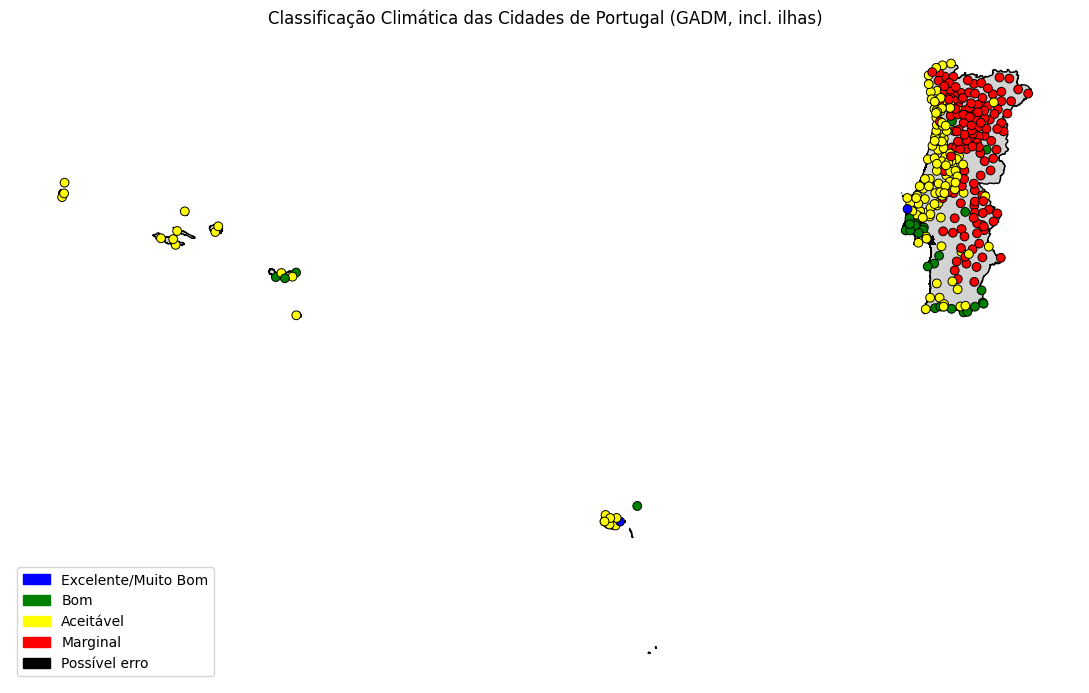

In [170]:
plot_map(df_resumo_geral_geo)

In [177]:
# Exemplo de uso:
cidades_lista = ['Monchique','Porto', 'Lisboa', 'Braga', 'Setubal']
plot_temperaturas(cidades_lista, df_resumo_mensal)